In [1]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import requests
import random
import pickle
import re
import spacy
from spacy import displacy
import collections
from collections import Counter
from tqdm.notebook import tqdm as tqdm_notebook


nlp = spacy.load('en_core_web_trf')

In [2]:
glossary = pickle.load(open('../../data/glossaries/FNA_glossary.pkl', 'rb'))

In [3]:
#glossary_FNA['Flower']

In [4]:
compound_list = [
    'fertile', 'sterile',
    'male', 'female', 'bisexual', 'hermaphroditic', 
    'basal', 'developed', 
    'primary', 'secondary', 'main',
    'upper', 'lower', 'greater', 'dorsal', 'alternate', 'lesser', 'apex', 'outer',
    'central', 'outermost', 'outer', 'inner', 'uppermost', 'median', 'dorsal', 'central', 'lateral',
    'young', 'mature', 'individual', 
    'opposite', 
]

rubbish = [
    '.', ',', '-', '..', '...', '', 
]

'''
measurements = [
    'mm', 'cm', 'm', 'km',
    'milimeter', 'centimeter', 'meter', 'kilometer',
    'milimetre', 'centimetre', 'metre', 'kilometre',
    'inch', 'foot', 'yard', 'mile',
    'wide', 'long', 'broad', 'tall',
    'length', 'form',
]
'''

"\nmeasurements = [\n    'mm', 'cm', 'm', 'km',\n    'milimeter', 'centimeter', 'meter', 'kilometer',\n    'milimetre', 'centimetre', 'metre', 'kilometre',\n    'inch', 'foot', 'yard', 'mile',\n    'wide', 'long', 'broad', 'tall',\n    'length', 'form',\n]\n"

In [5]:
glossary['compounds'] = compound_list

In [6]:
#data = pickle.load(open('../../data/PlantNet/descriptions_raw.pkl', 'rb'))
#data = pickle.load(open('../../data/description/04_TRAIN_0000000-0014557_PLANTS.pkl', 'rb'))

In [7]:
glossary['leaf'] += ['leave']

In [8]:
measurements_list = [
    'mm', 'cm', 'm', 'km',
    'milimeter', 'centimeter', 'meter', 'kilometer',
    'milimetre', 'centimetre', 'metre', 'kilometre',
    'inch', 'foot', 'yard', 'mile',
    'wide', 'long', 'broad', 'tall',
    'length', 'form',
]

In [9]:
def text_preparation(species, text):
    cleaners = [(r'(?<!\d)\.(?!\d)', ' '),
                (r'\s×\s', ' times '),
                #(r'\xa0', ' '),
                (r'\s+c\s+', ' '),
                (r'â\x80\x93', ' to '),
                (r'\xa0', ' '),
                (r'\x97', ''),
                (r'\s{2,}', ' ')]
    
    species_parts = species.split()
    candidates = [' '.join(species_parts[:idx+1]) for idx, _ in enumerate(species_parts)]
    candidates += [
        f'{species_parts[0][0]}. {species_parts[1]}'
    ]
    candidates.reverse()
    for candidate in candidates:
        try:
            text = re.sub(candidate, 'the species', text)
        except:
            continue # Skip species with brackets for now
    for (cleaner, replacement) in cleaners:
        text = re.sub(cleaner, replacement, text)    
    text = f'{text.strip()}.'
    return text.capitalize()

In [10]:
def extract_modifiers(t, doc):
    # Init list
    modifiers_dict = {}
    
    # AMODS
    amods = extract_amods(t, doc)
    for child in amods:
        amods = extract_modifiers(child, doc)
        modifiers_dict[child] = amods
        
    # AMOD MODIFIERS
    advs = extract_adjective_modifiers(t, doc)
    for child in advs:
        advs = extract_modifiers(child, doc)
        modifiers_dict[child] = advs
        
    # COMPOUNDS
    #compounds = extract_compounds(t, doc)
    #for child in compounds:
    #    compounds = extract_modifiers(child, doc)
    #    modifiers_dict[child] = compounds
        
    # APPOS
    appos = extract_appos(t, doc)
    for child in appos:
        appos = extract_modifiers(child, doc)
        modifiers_dict[child] = appos
        
    # Preposition
    #prep = extract_preps(t, doc)
    #for child in prep:
    #    prep = extract_modifiers(child, doc)
    #    modifiers_dict[child] = prep
    
    # Preposition Objects
    #prep_objs = extract_prep_ojects(t, doc)
    #for child in prep_objs:
    #    prep_objs = extract_modifiers(child, doc)
    #    modifiers_dict[child] = prep_objs
        
    # MEASUREMENTS
    measurements = extract_measurements(t, doc)
    for child in measurements:
        measurements = extract_modifiers(child, doc)
        modifiers_dict[child] = measurements 
        
    # MEASUREMENTS UNITS
    units = extract_units(t, doc)
    for child in units:
        units = extract_modifiers(child, doc)
        modifiers_dict[child] = units
        
    units_extra = extract_units_modifiers(t, doc)
    for child in units_extra:
        units_extra = extract_modifiers(child, doc)
        modifiers_dict[child] = units_extra
     
    # MEASUREMENTS UNITS MAX
    units_max = extract_units_max(t, doc)
    for child in units_max:
        units_max = extract_modifiers(child, doc)
        modifiers_dict[child] = units_max
        
        # MEASUREMENTS UNITS MIN
        units_min = extract_units_min(child, doc)
        for child in units_min:
            units_min = extract_modifiers(child, doc)
            modifiers_dict[child] = units_min     
       
    return modifiers_dict

def extract_amods(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'amod'
           and tok.lemma_ not in measurements_list and tok.lemma_ not in glossary['compounds']]

def extract_compounds(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'compound'
           and tok.lemma_ not in measurements_list]

def extract_appos(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'appos'
           and tok.lemma_ not in measurements_list]

def extract_preps(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'prep'
           and tok.lemma_ not in measurements_list]

def extract_prep_ojects(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'pobj'
           and tok.lemma_ not in measurements_list]

def extract_measurements(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'amod'
           and tok.lemma_ in measurements_list]

def extract_units(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'npadvmod'
           and tok.lemma_ in measurements_list]

def extract_units_modifiers(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'advmod'
           and tok.pos_ == 'NUM']

def extract_adjective_modifiers(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'advmod'
           and tok.pos_ == 'ADV']

def extract_units_max(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'nummod']

def extract_units_min(t, doc):
    return [tok for tok in t.children if tok.dep_ == 'quantmod']




In [11]:
def check_existance(t, doc):
    
    item = None
    for mainpart in glossary.keys():
        if t.lemma_.lower().strip() in glossary[mainpart]:
            item = mainpart
        if t.dep_ == 'compound':
            item = None
        if item == 'compounds':
            item = None
            
    return item
    
    
def extract_candidates(doc):
    
    return [t for t in doc 
            if t.pos_ == 'NOUN' 
            or t.pos_ == 'PROPN' 
            or t.pos_ == 'PRON']


def undict_to_pairs(d):
    for k, v in d.items():
        if isinstance(v, dict):
            for subk in v:
                yield (k, subk)
            yield from undict_to_pairs(v)
        #else:
        #    yield (k, v)
                
                
def extract_conjunctions(t):
    for tok in t.children:
        if tok.dep_ == 'conj':
            yield (tok)
        yield from extract_conjunctions(tok)

def extract_information(doc):
    
    doubles = []  
    
    # Get Candidates
    for candidate in extract_candidates(doc): 
        # Check if the candidate exist within the glossary
        existance = check_existance(candidate, doc)
        #print(existance, candidate)
                
        if existance:
            # Extract information
            information = {candidate: extract_modifiers(candidate, doc)}
            
            # Keep conjunctions outside of the main recursion
            candidate_conjunctions = extract_conjunctions(candidate)        
            for candidate_conjunction in candidate_conjunctions:
                information[candidate][candidate_conjunction] = extract_modifiers(candidate_conjunction, doc)
            
            # Candidates            
            candidates = [(existance, candidate), *list(undict_to_pairs(information))]
            #print(candidates)
            # Drop not found items
            if len(candidates) > 0:
                doubles_retok = retokenize_doubles(candidates, doc)
                doubles += [doubles_retok]

    return doubles


In [121]:
def retokenize_doubles(candidates, doc):
    
    retok_list = []
    # Create list to change stuff in place
    candidate_list = [list(item) for item in candidates]
    # Get Subject
    subject = candidate_list[0][1]
    # Get compounds
    compounds = [t for t in subject.children 
                 if t.lemma_ in glossary['compounds']
                 or t.dep_ == 'compound']
    if compounds:
        # Compounds of compounds
        for compound in compounds:
            compounds += [t for t in compound.children
                 if t.dep_ == 'compound']
        # Indices
        compounds_idx = [t.i for t in compounds]
        # Add to list
        compounds_idx.sort(reverse=True)
        for idx, compound_idx in enumerate(compounds_idx):
            candidate_list
            compound = doc[compound_idx : subject.i + 1]
            if idx == 0:
                candidate_list.insert(idx + 1, [subject, compound])
            else:
                candidate_list.insert(idx + 1, [previous_compound, compound])
            previous_compound = compound
        # Remove compound amods:
        for idx, information in enumerate(candidate_list[2:]):
            if information[0].text ==  subject.text:
                candidate_list[idx + 2] = [previous_compound, information[1]]
        #candidate_list = candidate_list[0:1] + compounds_removed    
    
    
    print(candidate_list)
    
    
    candidate_list_new_nodes = []
    measurements = ''
    for idx, candidate in enumerate(candidate_list):
        

                
        
        # QUANTITIES
        quantities = create_quantities(candidate)
        if quantities:
            candidate_list_new_nodes.extend(quantities)
        # MEASUREMENTS
        measurements = create_measurements(candidate, measurements)
        if measurements:
            candidate_list_new_nodes.extend(measurements)
        # ELSE
        else:
            candidate_list_new_nodes.extend([candidate])
        
    
    
    return candidate_list_new_nodes



def create_quantities(double):   
    node_1 = double[0]
    node_2 = double[1]
    quantity = []
    
    print(node_1, 333, node_2)
    
    if (
        type(node_1) != str 
        and type(node_2) != str
        and len(node_2.text.split()) == 1
        and len(node_2.text.split('-')) == 1
        and node_1.lemma_ not in measurements_list
        #and node_2.pos_ == 'NUM'
        and node_2.dep_ == 'nummod'
    ):
        if len(node_1.text.split()) == 1:
            quant = f'{node_1.lemma_}_quantity'.replace(' ', '_')
        else:
            quant = f'{node_1.root.lemma_}_quantity'.replace(' ', '_')
        quantity.append([node_1, quant])
        quantity.append([quant, node_2])
        
    return quantity

def create_measurements(double, previous_measurement):   
    node_1 = double[0]
    node_2 = double[1]
    measurements = []

    if (
        type(node_1) != str 
        and type(node_2) != str
        and len(node_2.text.split()) == 1
        and node_2.lemma_ in measurements_list
        and node_1.lemma_ not in measurements_list
    ):
        if node_2.lemma_ in ['wide', 'width']:
            if len(node_1.text.split()) == 1:                
                measu = f'{node_1.lemma_}_width'.replace(' ', '_')
            else:
                measu = f'{node_1.root.lemma_}_width'.replace(' ', '_')
        elif node_2.lemma_ in ['length', 'long']:
            if len(node_1.text.split()) == 1:                
                measu = f'{node_1.lemma_}_length'.replace(' ', '_')
                #print(node_1, measu)
            else:
                measu = f'{node_1.root.lemma_}_length'.replace(' ', '_')
        measurements.append([node_1, measu])
    
    if previous_measurement:
        #print(previous_measurement[0][1])
        if (
            type(previous_measurement[0][1]) == str 
        ):
            measurements.append([previous_measurement[0][1], node_2])
    return measurements
        


    

In [122]:
#data = pickle.load(open('../../data/description/04_TRAIN_0000000-0014557_PLANTS.pkl', 'rb'))
#data = pickle.load(open('../../data/PlantNet/descriptions_raw.pkl', 'rb'))

In [123]:
#data = {
#    'Test Tree':[
#        '5 slightly dark, upper female leaves without any blue veins.',
#        'Stems often 5-veined.',
#        'Branches light-dark reddish brown and greenish purple or black.'
#    ]
#}

In [124]:
descriptions = collections.defaultdict(list)

for species in tqdm_notebook(list(data.keys())[0:1]):
    for idx, text in enumerate(data[species][4:5]):
        text = text_preparation(species, text)
        doc = nlp(text)
        doubles = extract_information(doc)
        descriptions[species].append(doubles)
        print(doubles)
        

            
            
                   
                    
        #print(text)
        #print(idx, triples)
        #print('\n')
        #descriptions[species] += triples    

  0%|          | 0/1 [00:00<?, ?it/s]

[['leaf', blades], [blades, Leaf-blades], [Leaf-blades, flat], [Leaf-blades, wide], [Leaf-blades, conduplicate], [wide, long], [wide, cm], [wide, mm], [cm, 11], [cm, 6], [mm, 4], [mm, 3]]
leaf 333 blades
blades 333 Leaf-blades
Leaf-blades 333 flat
Leaf-blades 333 wide
Leaf-blades 333 conduplicate
wide 333 long
wide 333 cm
wide 333 mm
cm 333 11
cm 333 6
mm 333 4
mm 333 3
[[['leaf', blades], [blades, Leaf-blades], [Leaf-blades, flat], [Leaf-blades, 'leaf-blade_width'], ['leaf-blade_width', conduplicate], [wide, long], [wide, cm], [wide, mm], [cm, 11], [cm, 6], [mm, 4], [mm, 3]]]


In [ ]:
descriptions[species]

In [98]:
displacy.render(doc)

# VIZ

In [73]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from netgraph import Graph
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
#descriptions

In [92]:
temp = []
for information in descriptions[species]:
    for infor in information:
        for idx, info in enumerate(infor):

            item0 = info[0]
            item1 = info[1]
            
            if idx == 0:
                temp.append(('species', item0))
            
            if type(item0) != str:
                item0 = item0.lemma_
            if type(item1) != str:
                item1 = item1.lemma_
            temp.append((item0, item1))

In [93]:
source   = []
relation = []
target   = []


for (sub, obj) in temp:
    source.append(sub)
    relation.append('temp')
    target.append(obj)

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [94]:
#temp

In [95]:
nodes = [(source, target) for source, target in zip(kg_df['source'].values, kg_df['target'].values)]
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.Graph())


node_labels = {node : node for idx, node in enumerate(G)}
edge_labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))

node_size = {}
node_color = {}

size = 1.5

for node in node_labels:
    if node == 'species':
        node_size[node] = 3.5/size
        node_color[node] = 'darkgreen'
    else:
        node_size[node] = 1./size
        node_color[node] = 'white'
        
pos = nx.spring_layout(G, k = 0.08, iterations=5000, seed=3, scale=0.3, center=(0,0), dim=2)

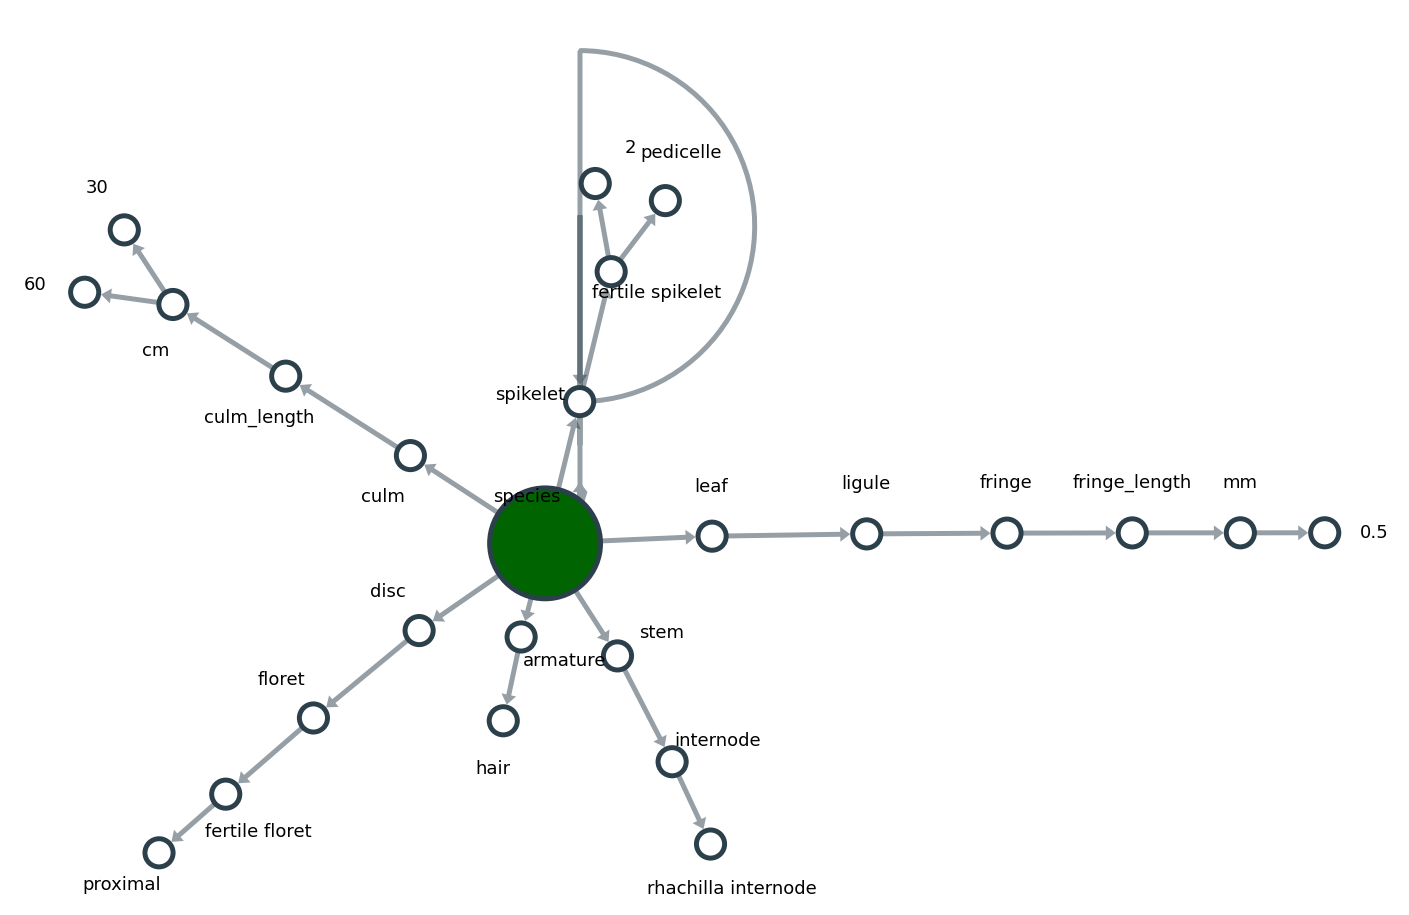

In [96]:
fig, ax = plt.subplots(figsize=(25, 25))
Graph(nodes, 
      #node_layout='spring', edge_layout='curved', 
      node_layout=pos, edge_layout='straight', 
      arrows=True, node_zorder=3, #edge_zorder=1,
      node_labels=node_labels, 
      node_label_offset=0.02, 
      #edge_labels=edge_labels,
      node_label_fontdict=dict(size=18, rotation=0, ha='center', clip_on=False), node_edge_width=0.2,
      node_size=node_size,  node_color=node_color, #edge_labels=edge_labels,
      edge_width=0.2, edge_label_fontdict=dict(size=10,),
      #node_layout_kwargs=dict(node_size=1, total_iterations=20),
      ax=ax)

In [ ]:
def retokenize_doubles(candidates, doc):
    
    retok_list = []
    # Create list to change stuff in place
    candidate_list = [list(item) for item in candidates]
    # Get Subject
    subject = candidate_list[0][1]
    
    
    print(candidate_list)
    
    ## Compounds
    # Find possible compounds
    compound_candidates = [item for item in candidate_list[1:] if item[0] == subject or item[0].dep_ == 'compound']
    
    #print(compound_candidates)
    
    # Extract compounds:
    compounds = [amod for (_, amod) in compound_candidates 
                 if amod.lemma_ in compound_list or amod.dep_ == 'compound']
    
    #print(compounds)
    #for compound in compounds:
        #print(compound)
        #compounds += [additional[1] for additional in candidate_list[1:] if additional[0] ==  compound]
    
    if compounds:
        compound_idx = min([compound.i for compound in compounds if compound.i < subject.i])
        compound = doc[compound_idx : subject.i + 1]
        # Replace in place (not faster but more convinient)
        for idx, (noun, info) in enumerate(candidate_list[1:]):
            if noun == subject:
                candidate_list[idx + 1] = [compound, info]
        # Remove compound amods:
        compounds_removed = [[information[0], information[1]] for information in candidate_list[1:]
                             if information[1].text not in information[0].text]
        candidate_list = candidate_list[0:1] + compounds_removed
        for idx, token in enumerate(reversed(compounds)):
            compound = doc[token.i : subject.i + 1]
            #print(compound, idx)
            if idx == 0:
                candidate_list.insert(idx + 1, [subject, compound])
            else:
                candidate_list.insert(idx + 1, [previous_compound, compound])
            previous_compound = compound
        
    
    #print(compounds)
    return candidate_list
    
